In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score
import string
import nltk
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Just taking the first 5500 records to limit the GPU usage
df = data.head(5500)
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Dataset columns
id: unique id for a news article

title: the title of a news article

author: author of the news article

text: the text of the article; could be incomplete

label: a label that marks the article as potentially unreliable
*   1: unreliable
*   0: reliable





In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5500 non-null   int64 
 1   title   5349 non-null   object
 2   author  4963 non-null   object
 3   text    5489 non-null   object
 4   label   5500 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 215.0+ KB


In [5]:
# As title and text are both very important in determining if a news is fake, drop the records with any of these blank.
df.dropna(subset=['title','text'], how='any', axis=0, inplace=True)

<ipython-input-5-744640940397>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['title','text'], how='any', axis=0, inplace=True)


In [6]:
df.isna().sum()

id          0
title       0
author    526
text        0
label       0
dtype: int64

In [7]:
# Author has some null values, so let us fill it with a value called 'Unknown'
df['author'] = df['author'].fillna('unknown')

<ipython-input-7-672f10d6ea1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author'] = df['author'].fillna('unknown')


# Data Preprocessing

In [8]:
# Data preprocessing 1: Convert entire title, author and text to lower case
df['title'] = df['title'].str.lower()
df['author'] = df['author'].str.lower()
df['text'] = df['text'].str.lower()

<ipython-input-8-c3a824d5f70d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].str.lower()
<ipython-input-8-c3a824d5f70d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author'] = df['author'].str.lower()
<ipython-input-8-c3a824d5f70d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [9]:
# Data preprocessing 2: Remove punctuations

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["title_wo_punct"] = df["title"].apply(lambda text: remove_punctuation(text))
df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text))

<ipython-input-9-7a52fb118f81>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_wo_punct"] = df["title"].apply(lambda text: remove_punctuation(text))
<ipython-input-9-7a52fb118f81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text))


In [10]:
# Data preprocessing 3: Remove stopwords, like I, me, our, ourselves, on etc.
from nltk.corpus import stopwords
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["title_wo_stop"] = df["title_wo_punct"].apply(lambda text: remove_stopwords(text))
df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-10-c0956fde9203>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_wo_stop"] = df["title_wo_punct"].apply(lambda text: remove_stopwords(text))
<ipython-input-10-c0956fde9203>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))


In [11]:
# Drop the columns that were converted during preprocessing
df.drop(['text', 'title', 'text_wo_punct', 'title_wo_punct'], axis=1, inplace=True)

<ipython-input-11-09da2ef11c21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['text', 'title', 'text_wo_punct', 'title_wo_punct'], axis=1, inplace=True)


In [12]:
df.head()

,id,author,label,title_wo_stop,text_wo_stop
0,0,darrell lucus,1,house dem aide didn’t even see comey’s letter ...,house dem aide didn’t even see comey’s letter ...
1,1,daniel j. flynn,0,flynn hillary clinton big woman campus breitbart,ever get feeling life circles roundabout rathe...
2,2,consortiumnews.com,1,truth might get fired,truth might get fired october 29 2016 tension ...
3,3,jessica purkiss,1,15 civilians killed single us airstrike identi...,videos 15 civilians killed single us airstrike...
4,4,howard portnoy,1,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six years prison...


In [13]:
# reset indexes
df.reset_index(inplace=True)

In [14]:
# Split the dataset into independent(X) and dependent(y) variables
X_before = df.drop('label', axis=1)
y = df['label']

print(X_before.shape)
print(y.shape)

(5338, 5)
(5338,)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

vectorizer = CountVectorizer()
columns = ['author','title_wo_stop','text_wo_stop']
transformer = make_column_transformer(*[(vectorizer, col) for col in columns])

X_before = transformer.fit_transform(X_before)

In [16]:
# convert the sparse matrix created above to a dataframe -- Crashing due to high RAM usage
# data_df = pd.DataFrame(df.toarray())

In [17]:
X = pd.DataFrame(X_before.todense())
print(X.shape)

(5338, 110332)


In [18]:
# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (3576, 110332)
Shape of y_train: (3576,)
Shape of X_test: (1762, 110332)
Shape of y_test: (1762,)


In [19]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,110322,110323,110324,110325,110326,110327,110328,110329,110330,110331
1519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y_train.head()

1519    0
5019    0
3836    1
3754    0
1023    0
Name: label, dtype: int64

In [21]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Naive Bayes Model Accuracy: 0.926
Confusion matrix, without normalization


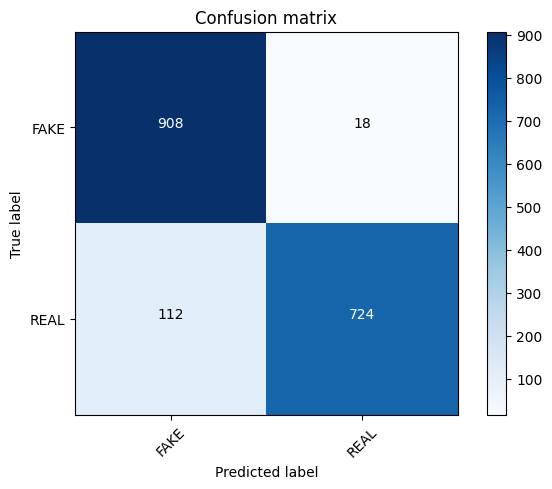

In [22]:
# Approach 1: Create a Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import itertools

classifier = MultinomialNB()

classifier.fit(X_train,y_train)

y_pred_nb = classifier.predict(X_test)

score = metrics.accuracy_score(y_test,y_pred_nb)

print("Naive Bayes Model Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_test,y_pred_nb)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

SVM Model Accuracy: 0.956
Confusion matrix, without normalization


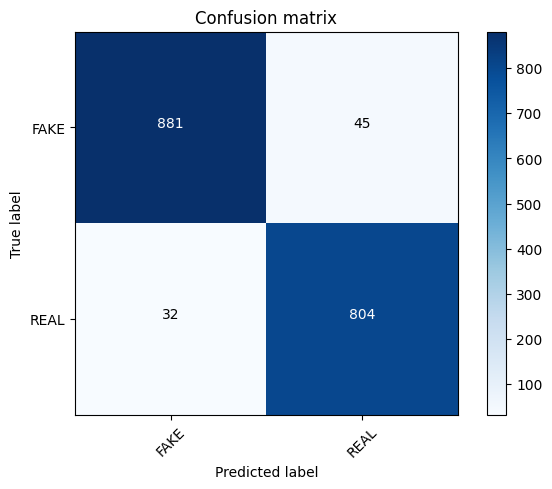

In [23]:
# Approach 2: Create a Support Vector Machine model
support = svm.LinearSVC(random_state=20)

support.fit(X_train, y_train)
y_pred_svm = support.predict(X_test)
score=accuracy_score(y_test,y_pred_svm)

print("SVM Model Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_test,y_pred_svm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])